# PACKAGES

In [30]:
import sqlite3
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [55]:
db = 'U62_PULSE_simulationstats.db'
con = sqlite3.connect(db)
df_sensors = pd.read_sql_query('SELECT * FROM sensors', con)
df_stats = pd.read_sql_query('SELECT * FROM standardstatistics', con)
df_simAttr = pd.read_sql_query('SELECT * FROM simulationattributes', con)
con.close()

# READ-IN DATA

In [91]:
def db_to_features(sensor_list, feature_list):
    '''
    ######TO IMPLEMENT THE DB: delete attributes (df_sensor, df_stats, df_simAttr) and uncomment the connection to the database#####
    This function reads the database and returns the tables of interest.
    It modifies the tables so that they are ready to be used in the analysis.

    Inputs:
    db: path to the database
    sensor_list: list of sensors to be used
    feature_list: list of features to be used

    Outputs:
    sim_results: table of simulation results
    caselist: table of simulation attributes
    cl_filtered: empty table to be populated with run simulations
    sr_filtered: empty table to be populated with run simulations
    sensors: table of sensors
    '''
 
    # groups of simulations (different seeds)
    groups = df_simAttr.loc[df_simAttr['name'] == 'GroupID'].set_index('simulation_id') #get groupID for each simulation
    groups = df_simAttr.loc[df_simAttr['name'] == 'GroupID'] #get groupID for each simulation
    groups = groups.rename(columns={'value':'GroupID'})[['simulation_id', 'GroupID']].astype(int) #rename and convert to int

    # filter simulation results
    sensors = df_sensors[df_sensors['name'].isin(sensor_list)] #filter 2348 sensors for 12
    sim_results = df_stats[df_stats['sensor_id'].isin(sensors['id'].unique())] #filter results of 2348 sensors for 12
    sim_results = sim_results.pivot(index='simulation_id', columns='sensor_id', values='max').sort_index()
    sim_results = sim_results.merge(groups, on='simulation_id').set_index('simulation_id') #join groups with sim_results on simulation_id

    # filter simulation attributes
    df_simAttr_filter = df_simAttr[df_simAttr['name'].isin(feature_list)] #filter 47 simulation attributes for 8
    caselist = df_simAttr_filter.pivot(index='simulation_id', columns='name', values='value') #pivot to get 1 row per simulation
    caselist = caselist.merge(groups, on='simulation_id').set_index('simulation_id') #join groups and caselist on simulation_id
    caselist = caselist.drop(5333) #drop simulation 5333 as it has no results

    caselist[['CurrentGeographic', 'WaveGeographic', 'WindGeographic', 'YawError', 'GroupID']] = caselist[['CurrentGeographic', 'WaveGeographic', 'WindGeographic', 'YawError', 'GroupID']].astype(int)
    caselist[['Uhub', 'Hs', 'Tp', 'CurrentSpeed']] = caselist[['Uhub', 'Hs', 'Tp', 'CurrentSpeed']].astype(float)

    # only returning one result per groupID for now
    mean_results = sim_results.groupby('GroupID').mean().reset_index()
    caselist_unique = caselist.groupby(caselist['GroupID']).first().reset_index()

    sim_results.to_csv('sim_results_og.csv')
    caselist.to_csv('caselist_og.csv')
    
    #create a new dataframe with the same columnnames as the caselist
    cl_filtered = caselist.iloc[0:0].copy()
    sr_filtered = sim_results.iloc[0:0].copy()
    
    return caselist_unique, mean_results

def encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

sensor_list = ['foundation_origin xy FloaterOffset [m]',
               'foundation_origin Rxy FloaterTilt [deg]',
               'foundation_origin Rz FloaterYaw [deg]',
               'foundation_origin z FloaterHeave [m]',
               'foundation_origin Mooring GXY Resultant force [kN]',
               'MooringLine1 Effective tension Fairlead [kN]',
               'MooringLine2 Effective tension Fairlead [kN]',
               'MooringLine3 Effective tension Fairlead [kN]',
               'MooringLine4 Effective tension Fairlead [kN]',
               'MooringLine5 Effective tension Fairlead [kN]',
               'GE14-220 GXY acceleration [m/s^2]',
               'CEN_E3 Resultant bending moment ArcLength=2.72 [kN.m]',
]
feature_list = ['WindGeographic',
                'Uhub',
                'WaveGeographic',
                'Hs',
                'YawError',
                'Tp',
                'CurrentGeographic',
                'CurrentSpeed',
]

In [92]:
caselist, sim_results = db_to_features(sensor_list, feature_list)
print(caselist.shape)
print(sim_results.shape)
caselist.head()

(1890, 9)
(1890, 13)


,GroupID,CurrentGeographic,CurrentSpeed,Hs,Tp,Uhub,WaveGeographic,WindGeographic,YawError
0,1,0,0.97,11.8,13.05,48.9,0,0,0
1,2,0,0.97,11.8,14.50,48.9,0,0,0
2,3,0,0.97,11.8,15.95,48.9,0,0,0
3,4,0,0.97,11.8,13.05,48.9,0,0,45
4,5,0,0.97,11.8,14.50,48.9,0,0,45


In [77]:
caselist = encode(caselist, 'CurrentGeographic', 360)
caselist = encode(caselist, 'WaveGeographic', 360)
caselist = encode(caselist, 'WindGeographic', 360)
caselist = encode(caselist, 'YawError', 360)
caselist.head()

,GroupID,CurrentGeographic,CurrentSpeed,Hs,Tp,Uhub,WaveGeographic,WindGeographic,YawError,CurrentGeographic_sin,CurrentGeographic_cos,WaveGeographic_sin,WaveGeographic_cos,WindGeographic_sin,WindGeographic_cos,YawError_sin,YawError_cos
0,1,0,0.97,11.8,13.05,48.9,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.000000
1,2,0,0.97,11.8,14.50,48.9,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.000000
2,3,0,0.97,11.8,15.95,48.9,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0,0.000000,1.000000
3,4,0,0.97,11.8,13.05,48.9,0,0,45,0.0,1.0,0.0,1.0,0.0,1.0,0.707107,0.707107
4,5,0,0.97,11.8,14.50,48.9,0,0,45,0.0,1.0,0.0,1.0,0.0,1.0,0.707107,0.707107


In [78]:
def plot_sin_cos(col): # Plotting
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 3, 1)
    plt.scatter(caselist[col], caselist[col+'_sin'], marker='o', linestyle='-')
    plt.title('Sin Transformation of Direction')
    plt.xlabel('Direction (degrees)')
    plt.ylabel('Sin(Transformed Value)')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.scatter(caselist[col], caselist[col+'_cos'], marker='o', linestyle='-')
    plt.title('Cos Transformation of Direction')
    plt.xlabel('Direction (degrees)')
    plt.ylabel('Cos(Transformed Value)')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.scatter(caselist[col+'_sin'], caselist[col+'_cos'], marker='o', linestyle='-')
    plt.title('Cos Transformation of Direction')
    plt.xlabel('Sin(Transformed Value)')
    plt.ylabel('Cos(Transformed Value)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

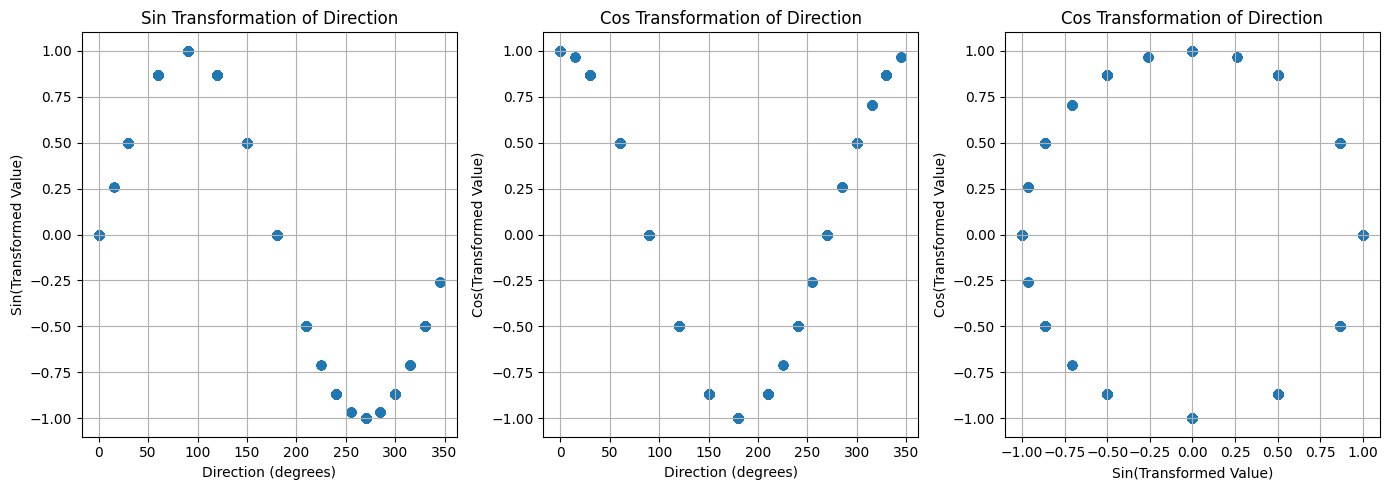

In [79]:
plot_sin_cos('CurrentGeographic')

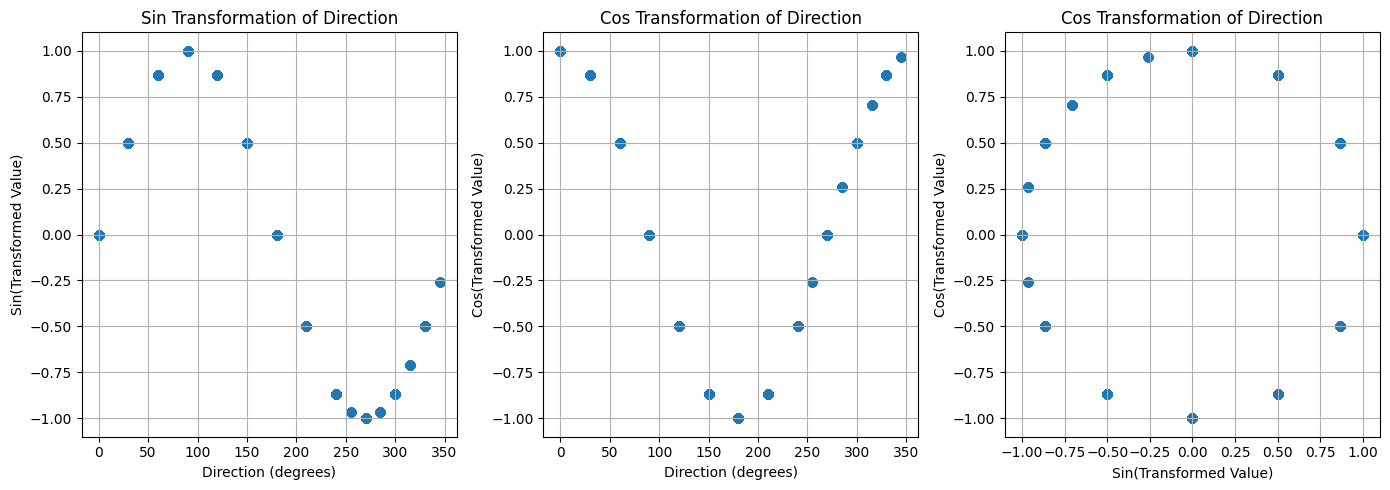

In [80]:
plot_sin_cos('WaveGeographic')

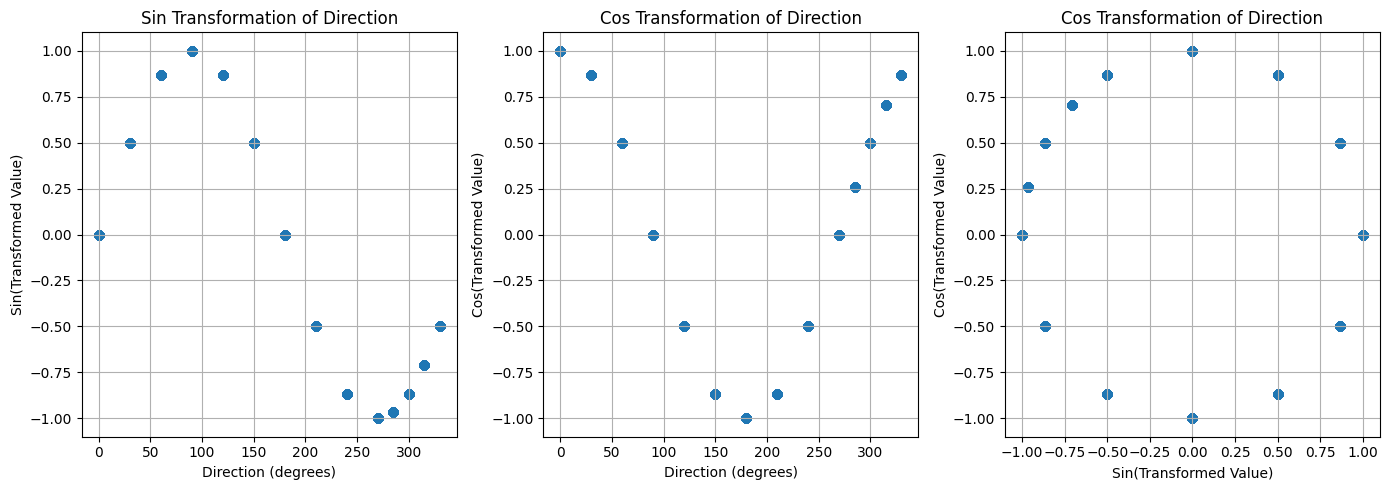

In [81]:
plot_sin_cos('WindGeographic')

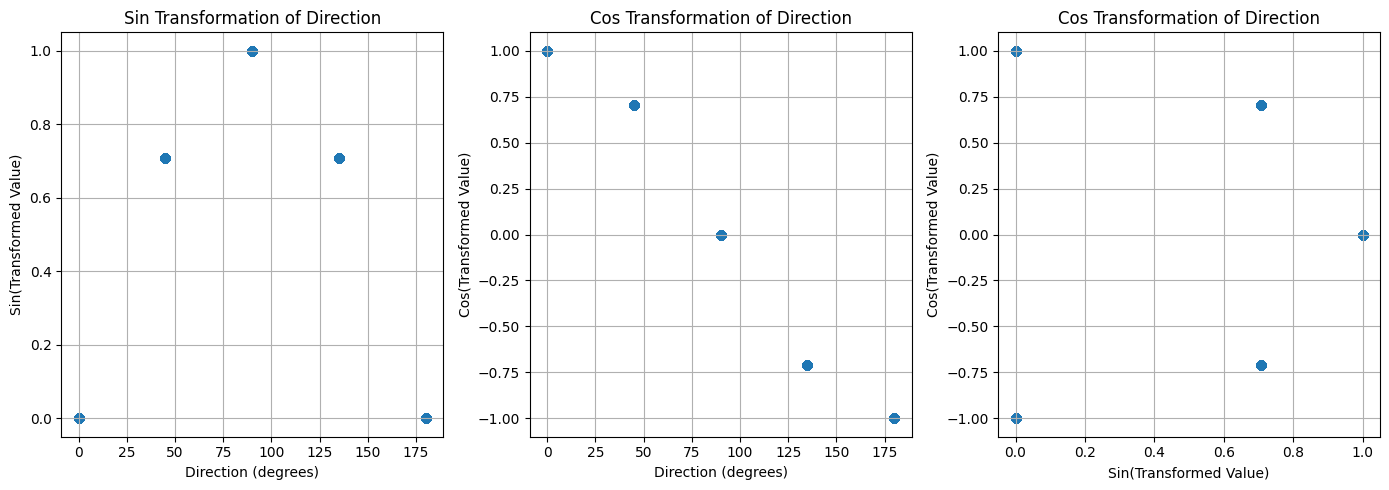

In [82]:
plot_sin_cos('YawError')

In [63]:
caselist_unique = caselist.groupby(caselist['GroupID']).first().reset_index()
print(caselist.shape)
print(caselist_unique.shape)

(5668, 9)
(1890, 9)


In [60]:
caselist.loc[1]

CurrentGeographic     90.00
CurrentSpeed           1.21
Hs                     6.10
Tp                     9.90
Uhub                  46.30
WaveGeographic        60.00
WindGeographic        60.00
YawError             135.00
GroupID              312.00
Name: 1, dtype: float64

In [61]:
caselist.loc[30]

CurrentGeographic     90.00
CurrentSpeed           1.21
Hs                     6.10
Tp                     9.90
Uhub                  46.30
WaveGeographic        60.00
WindGeographic        60.00
YawError             135.00
GroupID              312.00
Name: 30, dtype: float64

In [3]:
sim_results.value_counts('GroupID')[sim_results.value_counts('GroupID') != 3]


GroupID
1090    2
1063    2
Name: count, dtype: int64

In [4]:
caselist['WindGeographic'].value_counts()

WindGeographic
60     405
30     405
330    405
150    405
0      405
315    405
300    405
285    405
90     405
120    405
270    405
180    405
240    404
210    404
Name: count, dtype: int64

In [83]:
caselist

,GroupID,CurrentGeographic,CurrentSpeed,Hs,Tp,Uhub,WaveGeographic,WindGeographic,YawError,CurrentGeographic_sin,CurrentGeographic_cos,WaveGeographic_sin,WaveGeographic_cos,WindGeographic_sin,WindGeographic_cos,YawError_sin,YawError_cos
0,1,0,0.97,11.8,13.05,48.9,0,0,0,0.0,1.000000,0.0,1.0,0.0,1.000000,0.000000e+00,1.000000
1,2,0,0.97,11.8,14.50,48.9,0,0,0,0.0,1.000000,0.0,1.0,0.0,1.000000,0.000000e+00,1.000000
2,3,0,0.97,11.8,15.95,48.9,0,0,0,0.0,1.000000,0.0,1.0,0.0,1.000000,0.000000e+00,1.000000
3,4,0,0.97,11.8,13.05,48.9,0,0,45,0.0,1.000000,0.0,1.0,0.0,1.000000,7.071068e-01,0.707107
4,5,0,0.97,11.8,14.50,48.9,0,0,45,0.0,1.000000,0.0,1.0,0.0,1.000000,7.071068e-01,0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,1886,30,1.17,11.8,14.50,48.9,0,330,135,0.5,0.866025,0.0,1.0,-0.5,0.866025,7.071068e-01,-0.707107
1886,1887,30,1.17,11.8,15.95,48.9,0,330,135,0.5,0.866025,0.0,1.0,-0.5,0.866025,7.071068e-01,-0.707107
1887,1888,30,1.17,11.8,13.05,48.9,0,330,180,0.5,0.866025,0.0,1.0,-0.5,0.866025,1.224647e-16,-1.000000
1888,1889,30,1.17,11.8,14.50,48.9,0,330,180,0.5,0.866025,0.0,1.0,-0.5,0.866025,1.224647e-16,-1.000000


In [84]:
caselist_filtered = caselist.drop(['CurrentGeographic', 'WaveGeographic', 'WindGeographic', 'YawError'], axis=1)
caselist_filtered

,GroupID,CurrentSpeed,Hs,Tp,Uhub,CurrentGeographic_sin,CurrentGeographic_cos,WaveGeographic_sin,WaveGeographic_cos,WindGeographic_sin,WindGeographic_cos,YawError_sin,YawError_cos
0,1,0.97,11.8,13.05,48.9,0.0,1.000000,0.0,1.0,0.0,1.000000,0.000000e+00,1.000000
1,2,0.97,11.8,14.50,48.9,0.0,1.000000,0.0,1.0,0.0,1.000000,0.000000e+00,1.000000
2,3,0.97,11.8,15.95,48.9,0.0,1.000000,0.0,1.0,0.0,1.000000,0.000000e+00,1.000000
3,4,0.97,11.8,13.05,48.9,0.0,1.000000,0.0,1.0,0.0,1.000000,7.071068e-01,0.707107
4,5,0.97,11.8,14.50,48.9,0.0,1.000000,0.0,1.0,0.0,1.000000,7.071068e-01,0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,1886,1.17,11.8,14.50,48.9,0.5,0.866025,0.0,1.0,-0.5,0.866025,7.071068e-01,-0.707107
1886,1887,1.17,11.8,15.95,48.9,0.5,0.866025,0.0,1.0,-0.5,0.866025,7.071068e-01,-0.707107
1887,1888,1.17,11.8,13.05,48.9,0.5,0.866025,0.0,1.0,-0.5,0.866025,1.224647e-16,-1.000000
1888,1889,1.17,11.8,14.50,48.9,0.5,0.866025,0.0,1.0,-0.5,0.866025,1.224647e-16,-1.000000


In [85]:
caselist_filtered.to_csv('caselist.csv')

In [86]:
sensors

,id,name
48,49,foundation_origin z FloaterHeave [m]
51,52,foundation_origin Rz FloaterYaw [deg]
58,59,foundation_origin xy FloaterOffset [m]
59,60,foundation_origin Rxy FloaterTilt [deg]
163,164,CEN_E3 Resultant bending moment ArcLength=2.72...
1476,1477,MooringLine1 Effective tension Fairlead [kN]
1492,1493,MooringLine2 Effective tension Fairlead [kN]
1508,1509,MooringLine3 Effective tension Fairlead [kN]
1524,1525,MooringLine4 Effective tension Fairlead [kN]
1540,1541,MooringLine5 Effective tension Fairlead [kN]


In [87]:
sim_results

,GroupID,49,52,59,60,164,1477,1493,1509,1525,1541,1563,2348
0,1,3.641690,4.744566,28.170541,3.859987,545223.568598,2636.376628,1868.182861,1989.452026,7698.197428,3596.053141,8098.622960,3.077109
1,2,4.545901,0.898652,28.771844,3.731182,521949.626362,2482.106527,1807.729451,1872.254435,7625.719238,3408.941895,8005.953332,2.670720
2,3,4.469769,2.031366,28.347607,3.974630,468036.635680,2412.833089,1768.106242,1949.155070,7771.525553,3327.807617,7767.606475,2.386209
3,4,2.716954,3.469070,30.397904,5.759532,729098.671590,3178.914958,2286.855794,1588.076945,7976.302083,4396.402425,9343.292493,3.339900
4,5,3.477001,-0.073924,31.109725,6.270891,692740.416184,2870.001872,2079.517619,1572.595052,7910.671875,3925.814616,8918.474094,2.682204
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,1886,3.733195,-0.211397,30.515850,5.953782,689354.894901,2570.507243,1856.260457,1541.321940,8390.021647,3616.480713,8567.465780,2.743143
1886,1887,3.620160,0.315077,30.937133,6.180584,652888.200837,2521.273600,1842.511149,1629.399048,8902.977702,3620.156576,8829.969652,2.592859
1887,1888,3.199350,4.394077,29.675553,4.675129,608159.687689,2588.397868,1788.564575,1931.185343,8645.094564,3698.596680,8774.859798,2.986340
1888,1889,4.028750,1.888455,26.861148,5.036097,583012.811339,2411.850830,1728.675659,1802.109619,7313.997559,3346.949300,7449.177783,2.655583


In [88]:
column_mapping = pd.Series(sensors.name.values,index=sensors.id).to_dict()
column_mapping

{49: 'foundation_origin z FloaterHeave [m]',
 52: 'foundation_origin Rz FloaterYaw [deg]',
 59: 'foundation_origin xy FloaterOffset [m]',
 60: 'foundation_origin Rxy FloaterTilt [deg]',
 164: 'CEN_E3 Resultant bending moment ArcLength=2.72 [kN.m]',
 1477: 'MooringLine1 Effective tension Fairlead [kN]',
 1493: 'MooringLine2 Effective tension Fairlead [kN]',
 1509: 'MooringLine3 Effective tension Fairlead [kN]',
 1525: 'MooringLine4 Effective tension Fairlead [kN]',
 1541: 'MooringLine5 Effective tension Fairlead [kN]',
 1563: 'foundation_origin Mooring GXY Resultant force [kN]',
 2348: 'GE14-220 GXY acceleration [m/s^2]'}

In [89]:
sim_results_renamed = sim_results.rename(columns=column_mapping)
sim_results_renamed

,GroupID,foundation_origin z FloaterHeave [m],foundation_origin Rz FloaterYaw [deg],foundation_origin xy FloaterOffset [m],foundation_origin Rxy FloaterTilt [deg],CEN_E3 Resultant bending moment ArcLength=2.72 [kN.m],MooringLine1 Effective tension Fairlead [kN],MooringLine2 Effective tension Fairlead [kN],MooringLine3 Effective tension Fairlead [kN],MooringLine4 Effective tension Fairlead [kN],MooringLine5 Effective tension Fairlead [kN],foundation_origin Mooring GXY Resultant force [kN],GE14-220 GXY acceleration [m/s^2]
0,1,3.641690,4.744566,28.170541,3.859987,545223.568598,2636.376628,1868.182861,1989.452026,7698.197428,3596.053141,8098.622960,3.077109
1,2,4.545901,0.898652,28.771844,3.731182,521949.626362,2482.106527,1807.729451,1872.254435,7625.719238,3408.941895,8005.953332,2.670720
2,3,4.469769,2.031366,28.347607,3.974630,468036.635680,2412.833089,1768.106242,1949.155070,7771.525553,3327.807617,7767.606475,2.386209
3,4,2.716954,3.469070,30.397904,5.759532,729098.671590,3178.914958,2286.855794,1588.076945,7976.302083,4396.402425,9343.292493,3.339900
4,5,3.477001,-0.073924,31.109725,6.270891,692740.416184,2870.001872,2079.517619,1572.595052,7910.671875,3925.814616,8918.474094,2.682204
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,1886,3.733195,-0.211397,30.515850,5.953782,689354.894901,2570.507243,1856.260457,1541.321940,8390.021647,3616.480713,8567.465780,2.743143
1886,1887,3.620160,0.315077,30.937133,6.180584,652888.200837,2521.273600,1842.511149,1629.399048,8902.977702,3620.156576,8829.969652,2.592859
1887,1888,3.199350,4.394077,29.675553,4.675129,608159.687689,2588.397868,1788.564575,1931.185343,8645.094564,3698.596680,8774.859798,2.986340
1888,1889,4.028750,1.888455,26.861148,5.036097,583012.811339,2411.850830,1728.675659,1802.109619,7313.997559,3346.949300,7449.177783,2.655583


In [90]:
sim_results_renamed.to_csv('sim_results.csv')

# PREPARE DATA

In [ ]:
def prepare_data(input_df, output_df, output_col=59, test_size=0.2, random_state=42):
    X = input_df.copy()
    Y = output_df[output_col].copy()
    
    # Normalize the data
    scaler = MinMaxScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    Y_scaled = pd.DataFrame(scaler.fit_transform(Y.values.reshape(-1, 1)), columns=[Y.name])
    
    # Apply PCA to the normalized input data
    pca = PCA(n_components=1)
    X_pca = pca.fit_transform(X_scaled)
    X_pca = pd.DataFrame(X_pca, columns=['PC1'])
    #print how much variance is explained by the first principal component
    print('Variance explained by the first principal component:', pca.explained_variance_ratio_[0])
    
    # Split the data into train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y_scaled, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, Y_train, Y_test

x_train, x_test, y_train, y_test = prepare_data(caselist, sim_results)

In [ ]:
x_train_torch = torch.tensor(x_train.values, dtype=torch.float32).squeeze()
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32).squeeze()
x_test_torch = torch.tensor(x_test.values, dtype=torch.float32).squeeze()
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32).squeeze()

print(x_train_torch.shape, y_train_torch.shape, x_test_torch.shape)

# RUN MODEL

# EVALUATE OUTCOME

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))
rmse(preds['obs'], y_test_torch)